In [1]:
import pickle
import numpy as np

In [517]:
class NN(object):
    def __init__(self,
                 hidden_dims=(512, 256),
                 datapath='cifar10.pkl',
                 n_classes=10,
                 epsilon=1e-6,
                 lr=7e-4,
                 batch_size=1000,
                 seed=None,
                 activation="relu",
                 init_method="glorot"
                 ):

        self.hidden_dims = hidden_dims
        self.n_hidden = len(hidden_dims)
        self.datapath = datapath
        self.n_classes = n_classes
        self.lr = lr
        self.batch_size = batch_size
        self.init_method = init_method
        self.seed = seed
        self.activation_str = activation
        self.epsilon = epsilon

        self.train_logs = {'train_accuracy': [], 'validation_accuracy': [], 'train_loss': [], 'validation_loss': []}

        if datapath is not None:
            u = pickle._Unpickler(open(datapath, 'rb'))
            u.encoding = 'latin1'
            self.train, self.valid, self.test = u.load()
        else:
            self.train, self.valid, self.test = None, None, None

    def initialize_weights(self, dims):
        if self.seed is not None:
            np.random.seed(self.seed)

        self.weights = {}
        # self.weights is a dictionary with keys W1, b1, W2, b2, ..., Wm, Bm where m - 1 is the number of hidden layers
        all_dims = [dims[0]] + list(self.hidden_dims) + [dims[1]]
        #print(all_dims)
        for layer_n in range(1, self.n_hidden + 2):
            # WRITE CODE HERE
            self.weights[f"b{layer_n}"] = np.zeros((1, all_dims[layer_n]))
            #print(self.weights[f"b{layer_n}"].shape)
            
            nc_sqrt = np.sqrt(all_dims[layer_n-1])
            self.weights[f"W{layer_n}"] = np.random.uniform(low=-1/nc_sqrt, high=1/nc_sqrt, size=(all_dims[layer_n-1], all_dims[layer_n])) # verify matrix order
            #print(self.weights[f"W{layer_n}"])

    def relu(self, x, grad=False):
        indicatrice = np.where(x>0, 1, 0)
        if grad:
            # WRITE CODE HERE
            return indicatrice
        # WRITE CODE HERE
        return np.multiply(x,indicatrice)

    def sigmoid(self, x, grad=False):
        sig = 1 / (1 + np.exp(-x))
        if grad:
            # WRITE CODE HERE
            return sig - sig**2
        # WRITE CODE HERE
        return sig

    def tanh(self, x, grad=False):
        exp_pos = np.exp(x)
        exp_neg = np.exp(-x)
        tan_h = (exp_pos - exp_neg) / (exp_pos + exp_neg)
        if grad:
            # WRITE CODE HERE
            return 1 - tan_h**2
        # WRITE CODE HERE
        return tan_h

    def activation(self, x, grad=False):
        x = np.array(x)
        if self.activation_str == "relu":
            # WRITE CODE HERE
            res = self.relu(x, grad)
        elif self.activation_str == "sigmoid":
            # WRITE CODE HERE
            res = self.sigmoid(x, grad)
        elif self.activation_str == "tanh":
            # WRITE CODE HERE
            res = self.tanh(x, grad)
        else:
            raise Exception("invalid")
        return res

    def softmax(self, x):
        # Remember that softmax(x-C) = softmax(x) when C is a constant.
        # WRITE CODE HERE
        x = np.array(x)
        max_x = np.amax(x)
        x = x - max_x
        
        exp = np.exp(x)
        sum_exp = np.expand_dims(exp.sum(axis=len(exp.shape)-1), 1)
        res = exp / sum_exp
        return res

    def forward(self, x):
        cache = {"Z0": x}
        # cache is a dictionary with keys Z0, A0, ..., Zm, Am where m - 1 is the number of hidden layers
        # Ai corresponds to the preactivation at layer i, Zi corresponds to the activation at layer i
        # WRITE CODE HERE
        for layer_n in range(1,self.n_hidden + 2):
            # WRITE CODE HERE
            cache[f"A{layer_n}"] = (np.dot((self.weights[f"W{layer_n}"]).T, (cache[f"Z{layer_n - 1}"]).T) + (self.weights[f"b{layer_n}"]).T ).T   ### verify dimensions
            cache[f"Z{layer_n}"] = self.activation(cache[f"A{layer_n}"], grad=False)
            
            #print(cache[f"Z{layer_n}"].shape)
            #print(" ")
        #print(cache[f"A{self.n_hidden+1}"])
        cache[f"Z{self.n_hidden + 1}"] = self.softmax(cache[f"A{self.n_hidden + 1}"])    
        return cache

    def backward(self, cache, labels):
        output = cache[f"Z{self.n_hidden + 1}"]
        
        #output[np.where(output < self.epsilon)] = self.epsilon
        #output[np.where(output > 1 - self.epsilon)] = 1 - self.epsilon
        
        #pred = -(np.log(output))
        #loss = np.multiply(pred, labels) 

        # WRITE CODE HERE
        grads = {}
        grads[f"dA{self.n_hidden+1}"] = output - labels  
        grads[f"dW{self.n_hidden+1}"] = ((np.dot(grads[f"dA{self.n_hidden+1}"].T, cache[f"Z{self.n_hidden}"])).T) / labels.shape[0] 
        grads[f"db{self.n_hidden+1}"] = np.expand_dims(np.average(grads[f"dA{self.n_hidden+1}"],axis=0), axis=0)
        
        #print(grads[f"dA{self.n_hidden+1}"].shape)
        #print(grads[f"dW{self.n_hidden+1}"].shape)
        #print(grads[f"db{self.n_hidden+1}"].shape)
        #print(" ")
        
        # grads is a dictionary with keys dAm, dWm, dbm, dZ(m-1), dA(m-1), ..., dW1, db1
        # WRITE CODE HERE
        for layer_n in range(self.n_hidden, 0, -1):
            #print("loop: ", layer_n)
            
            #grads[f"dZ{layer_n}"] = (np.dot(self.weights[f"W{layer_n + 1}"], (cache[f"Z{layer_n + 1}"]).T)).T - (np.dot(self.weights[f"W{layer_n + 1}"], (labels).T)).T
            grads[f"dZ{layer_n}"] = (np.dot(self.weights[f"W{layer_n + 1}"], (grads[f"dA{layer_n + 1}"]).T)).T
            grads[f"dA{layer_n}"] = np.multiply(grads[f"dZ{layer_n}"], self.activation(cache[f"A{layer_n}"], grad=True))
            grads[f"dW{layer_n}"] = ((np.dot(grads[f"dA{layer_n}"].T, cache[f"Z{layer_n - 1}"])).T) / labels.shape[0]
            grads[f"db{layer_n}"] = np.expand_dims(np.average(grads[f"dA{layer_n}"],axis=0), axis=0)
            #grads[f"db{layer_n}"] = grads[f"dA{layer_n}"]
            
            #print(grads[f"dZ{layer_n}"].shape)
            #print(grads[f"dA{layer_n}"].shape)
            #print(grads[f"dW{layer_n}"].shape)
            #print(grads[f"db{layer_n}"].shape)
            
        return grads

    def update(self, grads):
        for layer in range(1, self.n_hidden + 2):
            # WRITE CODE HERE
            self.weights[f"W{layer}"] = self.weights[f"W{layer}"] - (self.lr * grads[f"dW{layer}"])
            self.weights[f"b{layer}"] = self.weights[f"b{layer}"] - (self.lr * grads[f"db{layer}"])

    def one_hot(self, y):
        # WRITE CODE HERE
        one_hot = np.zeros((y.shape[0], self.n_classes))
        for i, val in enumerate(y):
            one_hot[i, val] = 1
        return one_hot

    def loss(self, prediction, labels):
        prediction[np.where(prediction < self.epsilon)] = self.epsilon
        prediction[np.where(prediction > 1 - self.epsilon)] = 1 - self.epsilon
        # WRITE CODE HERE
        pred = -(np.log(prediction))
        loss = np.average(np.multiply(pred, labels).sum(axis=1))
        return loss

    def compute_loss_and_accuracy(self, X, y):
        one_y = self.one_hot(y)
        cache = self.forward(X)
        predictions = np.argmax(cache[f"Z{self.n_hidden + 1}"], axis=1)
        accuracy = np.mean(y == predictions)
        loss = self.loss(cache[f"Z{self.n_hidden + 1}"], one_y)
        return loss, accuracy, predictions

    def train_loop(self, n_epochs):
        X_train, y_train = self.train
        y_onehot = self.one_hot(y_train)
        dims = [X_train.shape[1], y_onehot.shape[1]]
        self.initialize_weights(dims)

        n_batches = int(np.ceil(X_train.shape[0] / self.batch_size))

        for epoch in range(n_epochs):
            for batch in range(n_batches):
                minibatchX = X_train[self.batch_size * batch:self.batch_size * (batch + 1), :]
                minibatchY = y_onehot[self.batch_size * batch:self.batch_size * (batch + 1), :]
                # WRITE CODE HERE
                cache = self.forward(minibatchX)
                grads = self.backward(cache, minibatchY)
                self.update(grads)

            X_train, y_train = self.train
            train_loss, train_accuracy, _ = self.compute_loss_and_accuracy(X_train, y_train)
            X_valid, y_valid = self.valid
            valid_loss, valid_accuracy, _ = self.compute_loss_and_accuracy(X_valid, y_valid)

            self.train_logs['train_accuracy'].append(train_accuracy)
            self.train_logs['validation_accuracy'].append(valid_accuracy)
            self.train_logs['train_loss'].append(train_loss)
            self.train_logs['validation_loss'].append(valid_loss)

        return self.train_logs

    def evaluate(self):
        X_test, y_test = self.test
        # WRITE CODE HERE
        test_loss, test_accuracy, _ = self.compute_loss_and_accuracy(X_test, y_test)
        return test_loss, test_accuracy


In [518]:
Q1= NN(seed=0, lr=0.003, batch_size=100, activation="relu")

0

In [510]:
#Q1.initialize_weights([3072, 10])

In [522]:
Q1.train_loop(50)

{'train_accuracy': [0.4779387755102041,
  0.4779387755102041,
  0.5365102040816326,
  0.4779387755102041,
  0.5365102040816326,
  0.5846734693877551,
  0.62,
  0.6489183673469388,
  0.6767551020408163,
  0.6945510204081633,
  0.7162244897959184,
  0.7331632653061224,
  0.7463061224489795,
  0.7562857142857143,
  0.7749183673469388,
  0.7861632653061225,
  0.7956326530612244,
  0.8015918367346939,
  0.8177959183673469,
  0.8227142857142857,
  0.8238163265306122,
  0.8385102040816327,
  0.8459183673469388,
  0.8463673469387755,
  0.8694081632653061,
  0.8685102040816327,
  0.8610204081632653,
  0.8777755102040816,
  0.8765102040816326,
  0.8791428571428571,
  0.8801428571428571,
  0.8921632653061224,
  0.8764081632653061,
  0.8899795918367347,
  0.891061224489796,
  0.9177755102040817,
  0.910530612244898,
  0.9123469387755102,
  0.9178775510204081,
  0.9294897959183673,
  0.9318775510204081,
  0.9328367346938775,
  0.9273061224489796,
  0.9341020408163265,
  0.9222448979591836,
  0.9342

Text(0.5, 1.0, 'Évolution des précisions sur 50 époques')

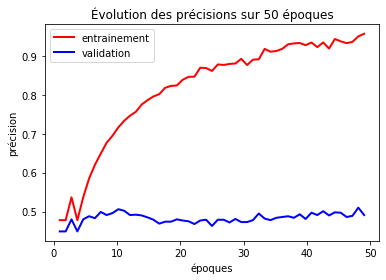

In [549]:
import matplotlib.pyplot as plt

x = (np.array(range(1, len(Q1.train_logs['validation_accuracy'])+1)) / (len(Q1.train_logs['validation_accuracy'])+1)) * 50
plt.plot(x, Q1.train_logs['train_accuracy'],color='red', linewidth=2)
plt.plot(x, Q1.train_logs['validation_accuracy'], color='blue', linewidth=2)
plt.legend(["entrainement", "validation"])
plt.xlabel("époques")
plt.ylabel("précision")
plt.title("Évolution des précisions sur 50 époques")


Text(0.5, 1.0, 'Évolution des coûts sur 50 époques')

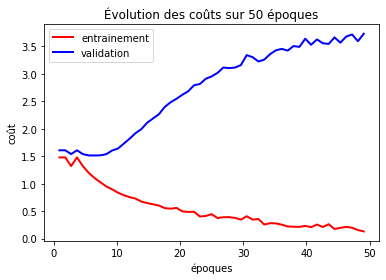

In [553]:
x = (np.array(range(1, len(Q1.train_logs['validation_loss'])+1)) / (len(Q1.train_logs['validation_loss'])+1)) * 50
plt.plot(x, Q1.train_logs['train_loss'],color='red', linewidth=2)
plt.plot(x, Q1.train_logs['validation_loss'], color='blue', linewidth=2)
plt.legend(["entrainement", "validation"])
plt.xlabel("époques")
plt.ylabel("coût")
plt.title("Évolution des coûts sur 50 époques")

In [554]:
Q3= NN(seed=0, lr=0.003, batch_size=100, activation="relu", hidden_dims=(512, 120, 120, 120, 120, 120, 120))

In [556]:
Q3.train_loop(50)

{'train_accuracy': [0.25487755102040816,
  0.3640204081632653,
  0.4256938775510204,
  0.46279591836734696,
  0.4911020408163265,
  0.5197142857142857,
  0.5443469387755102,
  0.5642857142857143,
  0.5857551020408164,
  0.6052448979591837,
  0.622938775510204,
  0.6359795918367347,
  0.6506326530612245,
  0.6619795918367347,
  0.6790612244897959,
  0.6816734693877551,
  0.693734693877551,
  0.6996326530612245,
  0.6969183673469388,
  0.7183265306122449,
  0.7345102040816327,
  0.7471224489795918,
  0.7315306122448979,
  0.7711224489795918,
  0.7624693877551021,
  0.8008979591836735,
  0.7869795918367347,
  0.8036734693877551,
  0.794,
  0.813795918367347,
  0.8275102040816327,
  0.824469387755102,
  0.8267142857142857,
  0.8382448979591837,
  0.8156122448979591,
  0.8388775510204082,
  0.8581836734693877,
  0.8723673469387755,
  0.8622857142857143,
  0.8433877551020408,
  0.860734693877551,
  0.878061224489796,
  0.8735918367346939,
  0.8861224489795918,
  0.869,
  0.8698367346938776,


Text(0.5, 1.0, 'Évolution des précisions sur 50 époques')

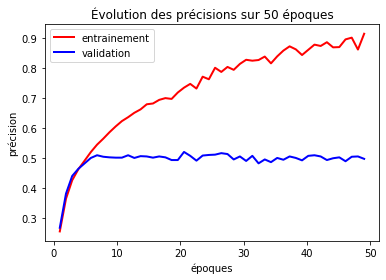

In [557]:
x = (np.array(range(1, len(Q3.train_logs['validation_accuracy'])+1)) / (len(Q3.train_logs['validation_accuracy'])+1)) * 50
plt.plot(x, Q3.train_logs['train_accuracy'],color='red', linewidth=2)
plt.plot(x, Q3.train_logs['validation_accuracy'], color='blue', linewidth=2)
plt.legend(["entrainement", "validation"])
plt.xlabel("époques")
plt.ylabel("précision")
plt.title("Évolution des précisions sur 50 époques")

Text(0.5, 1.0, 'Évolution des coûts sur 50 époques')

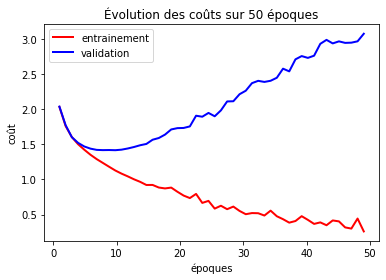

In [558]:
x = (np.array(range(1, len(Q3.train_logs['validation_loss'])+1)) / (len(Q3.train_logs['validation_loss'])+1)) * 50
plt.plot(x, Q3.train_logs['train_loss'],color='red', linewidth=2)
plt.plot(x, Q3.train_logs['validation_loss'], color='blue', linewidth=2)
plt.legend(["entrainement", "validation"])
plt.xlabel("époques")
plt.ylabel("coût")
plt.title("Évolution des coûts sur 50 époques")

In [559]:
Q1a= NN(seed=1, lr=0.003, batch_size=100, activation="relu")
Q1a.train_loop(50)

{'train_accuracy': [0.47461224489795917,
  0.5293265306122449,
  0.573469387755102,
  0.6092244897959184,
  0.6394489795918368,
  0.6654897959183673,
  0.6843469387755102,
  0.7093673469387755,
  0.7257755102040816,
  0.7364489795918367,
  0.7550204081632653,
  0.7628775510204082,
  0.7782857142857142,
  0.7899183673469388,
  0.8025714285714286,
  0.808795918367347,
  0.8093877551020409,
  0.815734693877551,
  0.8373061224489796,
  0.8430204081632653,
  0.8535714285714285,
  0.8503469387755102,
  0.8619795918367347,
  0.8472448979591837,
  0.8707551020408163,
  0.8761836734693877,
  0.8743673469387755,
  0.8903673469387755,
  0.8839183673469387,
  0.8905918367346939,
  0.9058979591836734,
  0.9040612244897959,
  0.9133877551020408,
  0.9010408163265307,
  0.9081428571428571,
  0.9140612244897959,
  0.9068163265306123,
  0.9161020408163265,
  0.9214489795918367,
  0.9185714285714286,
  0.9241428571428572,
  0.9254081632653062,
  0.9373265306122449,
  0.9395918367346939,
  0.934163265306

In [560]:
Q1b= NN(seed=2, lr=0.003, batch_size=100, activation="relu")
Q1b.train_loop(50)

{'train_accuracy': [0.4816326530612245,
  0.545469387755102,
  0.5871836734693877,
  0.6251836734693877,
  0.6552244897959184,
  0.6805102040816327,
  0.7019183673469388,
  0.7181224489795919,
  0.7340408163265306,
  0.7536326530612245,
  0.7675102040816326,
  0.7845918367346939,
  0.7929183673469388,
  0.808,
  0.8160408163265306,
  0.8148979591836735,
  0.8290612244897959,
  0.8308163265306122,
  0.8361632653061224,
  0.837,
  0.8503061224489796,
  0.8643469387755102,
  0.8584693877551021,
  0.8599183673469388,
  0.8597959183673469,
  0.8738571428571429,
  0.8722244897959184,
  0.889061224489796,
  0.898,
  0.8947142857142857,
  0.8917142857142857,
  0.9001428571428571,
  0.9092244897959184,
  0.9206530612244898,
  0.9260816326530612,
  0.9254489795918367,
  0.9145102040816326,
  0.9181428571428571,
  0.9260204081632653,
  0.9386530612244898,
  0.9251836734693878,
  0.9371428571428572,
  0.9400816326530612,
  0.9300612244897959,
  0.9485510204081633,
  0.9440408163265306,
  0.9307346

In [561]:
Q1c= NN(seed=3, lr=0.003, batch_size=100, activation="relu")
Q1c.train_loop(50)

{'train_accuracy': [0.47991836734693877,
  0.5401428571428571,
  0.5858775510204082,
  0.6176734693877551,
  0.6503673469387755,
  0.6740612244897959,
  0.6929795918367347,
  0.7157142857142857,
  0.7301632653061224,
  0.750061224489796,
  0.7597755102040816,
  0.7776122448979592,
  0.7924897959183673,
  0.8024489795918367,
  0.8119183673469388,
  0.8153673469387756,
  0.8242244897959183,
  0.8401836734693877,
  0.8428571428571429,
  0.8511836734693877,
  0.8535918367346939,
  0.8641428571428571,
  0.87,
  0.8708775510204082,
  0.8743673469387755,
  0.8723265306122449,
  0.8693877551020408,
  0.8742040816326531,
  0.884734693877551,
  0.8920816326530612,
  0.8975510204081633,
  0.8996530612244898,
  0.9098775510204081,
  0.9037755102040816,
  0.9239387755102041,
  0.919795918367347,
  0.9132040816326531,
  0.9227551020408163,
  0.9250204081632653,
  0.9318367346938775,
  0.9371020408163265,
  0.9393061224489796,
  0.9421020408163265,
  0.9384489795918367,
  0.9436734693877551,
  0.9428

In [650]:
Q3a= NN(seed=1, lr=0.003, batch_size=100, activation="relu", hidden_dims=(512, 120, 120, 120, 120, 120, 120))
Q3a.train_loop(50)

{'train_accuracy': [0.26210204081632654,
  0.35914285714285715,
  0.42120408163265305,
  0.4610612244897959,
  0.48920408163265305,
  0.5143061224489796,
  0.5391020408163265,
  0.5619591836734694,
  0.5828367346938775,
  0.5998979591836735,
  0.6187755102040816,
  0.6343265306122449,
  0.645469387755102,
  0.6569387755102041,
  0.6586326530612245,
  0.6569387755102041,
  0.679,
  0.6995918367346938,
  0.7078571428571429,
  0.7288163265306122,
  0.7105510204081633,
  0.745265306122449,
  0.7361020408163266,
  0.7436122448979592,
  0.7712857142857142,
  0.7675918367346939,
  0.7809795918367347,
  0.7268775510204082,
  0.7719387755102041,
  0.7959591836734694,
  0.8080612244897959,
  0.7974081632653062,
  0.8283265306122449,
  0.811795918367347,
  0.7832857142857143,
  0.8278367346938775,
  0.8136122448979591,
  0.8231020408163265,
  0.8170816326530612,
  0.7983469387755102,
  0.849326530612245,
  0.8069795918367347,
  0.8588775510204082,
  0.8643673469387755,
  0.8641224489795918,
  0.8

In [651]:
Q3b= NN(seed=2, lr=0.003, batch_size=100, activation="relu", hidden_dims=(512, 120, 120, 120, 120, 120, 120))
Q3b.train_loop(50)

{'train_accuracy': [0.2624489795918367,
  0.37281632653061225,
  0.424,
  0.45893877551020407,
  0.4876122448979592,
  0.5143061224489796,
  0.5344897959183673,
  0.5558571428571428,
  0.5755510204081633,
  0.5933061224489796,
  0.6105102040816327,
  0.6274897959183674,
  0.6393265306122449,
  0.6542448979591837,
  0.666,
  0.6736734693877551,
  0.6827142857142857,
  0.6996122448979591,
  0.7042857142857143,
  0.7129183673469388,
  0.7190816326530612,
  0.7234693877551021,
  0.7333061224489796,
  0.7501020408163265,
  0.7644285714285715,
  0.7815918367346939,
  0.7692857142857142,
  0.7573469387755102,
  0.7993877551020409,
  0.8013877551020409,
  0.8278979591836735,
  0.771061224489796,
  0.8309795918367346,
  0.8321224489795919,
  0.8028979591836735,
  0.8313265306122449,
  0.825204081632653,
  0.7969591836734694,
  0.8231428571428572,
  0.8688571428571429,
  0.848,
  0.8521224489795919,
  0.8876938775510204,
  0.8856530612244898,
  0.8832448979591837,
  0.8371224489795919,
  0.85616

In [652]:
Q3c= NN(seed=3, lr=0.003, batch_size=100, activation="relu", hidden_dims=(512, 120, 120, 120, 120, 120, 120))
Q3c.train_loop(50)

{'train_accuracy': [0.27453061224489794,
  0.36612244897959184,
  0.4207142857142857,
  0.46091836734693875,
  0.4913877551020408,
  0.516795918367347,
  0.5396530612244897,
  0.5600612244897959,
  0.5813469387755102,
  0.6012448979591837,
  0.619,
  0.6353265306122449,
  0.6503469387755102,
  0.6656530612244898,
  0.6779591836734694,
  0.6906938775510204,
  0.7041224489795919,
  0.7117551020408164,
  0.7261836734693877,
  0.7299183673469388,
  0.7471632653061224,
  0.7418571428571429,
  0.7537959183673469,
  0.7704489795918368,
  0.7639183673469387,
  0.7787755102040816,
  0.7767142857142857,
  0.7801224489795918,
  0.7993265306122449,
  0.7864489795918367,
  0.8115102040816327,
  0.8126938775510204,
  0.8212244897959183,
  0.8356530612244898,
  0.8234489795918367,
  0.8307346938775511,
  0.8216734693877551,
  0.8397959183673469,
  0.8539183673469388,
  0.8676122448979592,
  0.881734693877551,
  0.8470612244897959,
  0.8610612244897959,
  0.751061224489796,
  0.8919183673469387,
  0.8

In [588]:
v2 = np.expand_dims(np.array(Q1a.train_logs['validation_accuracy']), axis=0)
v3 = np.expand_dims(np.array(Q1b.train_logs['validation_accuracy']), axis=0)
v4 = np.expand_dims(np.array(Q1c.train_logs['validation_accuracy']), axis=0)
Q1_val = np.concatenate((v2, v3, v4), axis=0)

In [589]:
t2 = np.expand_dims(np.array(Q1a.train_logs['train_accuracy']), axis=0)
t3 = np.expand_dims(np.array(Q1b.train_logs['train_accuracy']), axis=0)
t4 = np.expand_dims(np.array(Q1c.train_logs['train_accuracy']), axis=0)
Q1_train = np.concatenate((t2, t3, t4), axis=0)

In [606]:
Q1_val_avg = np.average(Q1_val, axis=0)
Q1_train_avg = np.average(Q1_train, axis=0)

Q1_val_std = np.std(Q1_val, axis=0)
Q1_train_std = np.std(Q1_train, axis=0)

In [657]:
va2 = np.expand_dims(np.array(Q3a.train_logs['validation_accuracy']), axis=0)
va3 = np.expand_dims(np.array(Q3b.train_logs['validation_accuracy']), axis=0)
va4 = np.expand_dims(np.array(Q3c.train_logs['validation_accuracy']), axis=0)
Q3_val = np.concatenate((va2, va3, va4), axis=0)

In [658]:
ta2 = np.expand_dims(np.array(Q3a.train_logs['train_accuracy']), axis=0)
ta3 = np.expand_dims(np.array(Q3b.train_logs['train_accuracy']), axis=0)
ta4 = np.expand_dims(np.array(Q3c.train_logs['train_accuracy']), axis=0)
Q3_train = np.concatenate((ta2, ta3, ta4), axis=0)

In [659]:
Q3_val_avg = np.average(Q3_val, axis=0)
Q3_train_avg = np.average(Q3_train, axis=0)

Q3_val_std = np.std(Q3_val, axis=0)
Q3_train_std = np.std(Q3_train, axis=0)

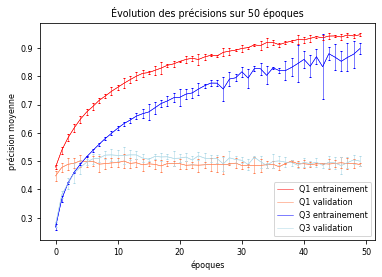

In [687]:
x = np.array(range(0, len(Q1_val_avg)))
plt.plot(x, Q1_train_avg, color='red', linewidth=0.5)
plt.plot(x, Q1_val_avg, color='coral', linewidth=0.5)

plt.plot(x, Q3_train_avg, color='blue', linewidth=0.5)
plt.plot(x, Q3_val_avg, color='lightblue', linewidth=0.5)

plt.legend(["Q1 entrainement", "Q1 validation", "Q3 entrainement", "Q3 validation"])
plt.xlabel("époques")
plt.ylabel("précision moyenne")
plt.title("Évolution des précisions sur 50 époques")

plt.errorbar(x, Q1_train_avg, yerr=Q1_train_std*1.96, color = 'red', linewidth=0.5, capsize=1)
plt.errorbar(x, Q1_val_avg, yerr=Q1_val_std*1.96, color = 'coral', linewidth=0.5, capsize=1)

plt.errorbar(x, Q3_train_avg, yerr=Q3_train_std*1.96, color = 'blue', linewidth=0.5, capsize=1)
plt.errorbar(x, Q3_val_avg, yerr=Q3_val_std*1.96, color = 'lightblue', linewidth=0.5, capsize=1)

plt.rcParams.update({'font.size': 8})